# **Sistema de recomendação por imagens**

Este projeto tem como objetivo desenvolver um **Sistema de Recomendação** baseado em imagens, capaz de sugerir produtos semelhantes visualmente a partir de uma busca na internet. Diferente dos sistemas tradicionais, que utilizam informações textuais como preço, marca e modelo, este modelo utilizará Deep Learning para identificar **similaridades visuais**, como formato, cor e textura.

## Agradecimentos para Jonathan Oheix:

- https://www.kaggle.com/code/jonathanoheix/product-recommendation-based-on-visual-similarity/notebook

## **Passo 1**
### Baixando a Base de Dados e as Bibliotecas Necessárias.


In [15]:
import kagglehub
path = kagglehub.dataset_download("olgabelitskaya/style-color-images/versions/7")

In [16]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

## **Passo 2**
### Carregando a imagem e o modelo

In [17]:
imgs_model_width, imgs_model_height = 224, 224 #Padronizando a altura e largura da imagem
nb_closest_images = 5 # Numero de imagens semelhantes que vai apresentar no final

In [18]:
vgg_model = vgg16.VGG16(weights='imagenet') #Carregando o modelo

feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
# Removendo as últimas camadas para obter recursos em vez de previsões

feat_extractor.summary() #print dos layers da CNN

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

Números de Imagens encontradas: 2184


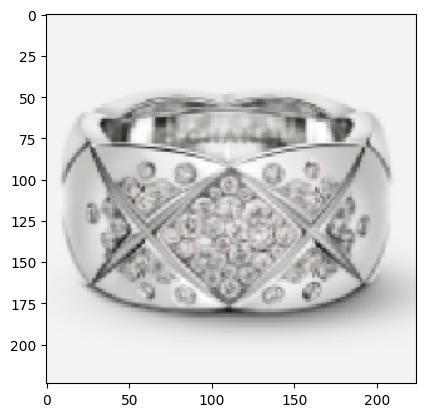

Imagem Carregada com Sucesso!


In [19]:
# Caminho onde os dados foram baixados
imgs_path = os.path.join(path, 'style')  # Ajuste se necessário

# Listar todos os arquivos de imagem na pasta
image_files = [os.path.join(imgs_path, x) for x in os.listdir(imgs_path) if x.endswith(".png")]

print("Números de Imagens encontradas:", len(image_files))

# Verificar se há imagens para carregar
if image_files:
    # Carregar a primeira imagem
    img_path = image_files[0]
    original = load_img(img_path, target_size=(imgs_model_width, imgs_model_height))

    # Mostrar a imagem
    plt.imshow(original)
    plt.show()
    print("Imagem Carregada com Sucesso!")
else:
    print("Imagens não encontradas.")

## **Passo 3**
### Manipulação e Preparação da Imagem para o modelo

In [20]:
# Em Numpy, a imagem é representada no formato (altura, largura, canais de cor).
numpy_image = img_to_array(original)

# Convertendo a imagem para o formato de lote (batch)
# A função expand_dims adiciona uma nova dimensão à matriz de dados em um eixo específico.
# Para alimentar a rede neural, precisamos do formato (tamanho_do_lote, altura, largura, canais).
# Como estamos processando uma única imagem, adicionamos uma dimensão extra no eixo 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('Tamanho do lote da Imagem', image_batch.shape)

# Preparando a imagem para ser usada no modelo VGG
processed_image = preprocess_input(image_batch.copy())

Tamanho do lote da Imagem (1, 224, 224, 3)


In [21]:
#Extração de Features
img_features = feat_extractor.predict(processed_image)

print("Features Extraida com Sucesso!")
print("number of image features:",img_features.size)
img_features

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
Features Extraida com Sucesso!
number of image features: 4096


array([[1.1715336, 3.4927092, 0.       , ..., 3.500734 , 0.       ,
        2.4746459]], dtype=float32)

In [22]:
importedImages = []

for f in image_files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [23]:
imgs_features = feat_extractor.predict(processed_imgs)

print("Features Extraida com Successo!")
imgs_features.shape

69/69 ━━━━━━━━━━━━━━━━━━━━ 1350s 20s/step
Features Extraida com Successo!


(2184, 4096)

In [24]:
files = [os.path.basename(f) for f in image_files]

# Calculando a similaridade do cosseno
cosSimilarities = cosine_similarity(imgs_features)

# Criando DataFrame usando `files` como índice e colunas
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)

# Exibindo as primeiras linhas do DataFrame
cos_similarities_df.head()

,1_6_008.png,1_9_026.png,5_2_010.png,4_5_008.png,6_4_015.png,6_4_013.png,6_1_020.png,1_4_024.png,2_9_015.png,6_9_002.png,...,3_0_078.png,0_1_002.png,5_2_068.png,1_0_052.png,4_1_010.png,0_0_089.png,2_0_068.png,1_7_017.png,4_1_036.png,3_0_007.png
1_6_008.png,1.000000,0.390241,0.275247,0.334642,0.264258,0.211540,0.235632,0.315455,0.252008,0.293406,...,0.209697,0.199588,0.281447,0.345121,0.209798,0.441564,0.326762,0.334212,0.221044,0.420558
1_9_026.png,0.390241,1.000000,0.425744,0.385758,0.422545,0.435743,0.297322,0.481773,0.579444,0.514910,...,0.175991,0.422329,0.273545,0.472516,0.317489,0.465804,0.444415,0.572453,0.246126,0.466741
5_2_010.png,0.275247,0.425744,1.000000,0.267578,0.269795,0.299727,0.378948,0.211258,0.271648,0.534820,...,0.152912,0.316087,0.336869,0.404459,0.544166,0.315574,0.299299,0.389392,0.299792,0.425553
4_5_008.png,0.334642,0.385758,0.267578,1.000000,0.387814,0.275609,0.279327,0.450826,0.368462,0.352903,...,0.149677,0.298365,0.278407,0.216261,0.282700,0.242965,0.282661,0.352471,0.253275,0.307085
6_4_015.png,0.264258,0.422545,0.269795,0.387814,1.000000,0.336190,0.202855,0.523297,0.326810,0.309511,...,0.246409,0.217605,0.441576,0.279481,0.231750,0.370410,0.455454,0.526646,0.157988,0.297374


## **Passo 4**

### Criando a Função de Recomendação

In [25]:
def retrieve_most_similar_products(given_img):

    print("--"*30)
    print("Produto Original:")

    # Construindo o caminho da imagem ao diretório base
    given_img_path = os.path.join(imgs_path, given_img)

    original = load_img(given_img_path, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("--"*30)
    print("Produto Mais Similar:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        # Construindo o caminho da imagem para imagens semelhantes
        closest_img_path = os.path.join(imgs_path, closest_imgs[i])
        original = load_img(closest_img_path, target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

## **Passo 5**
### Executando a Função


------------------------------------------------------------
Produto Original:


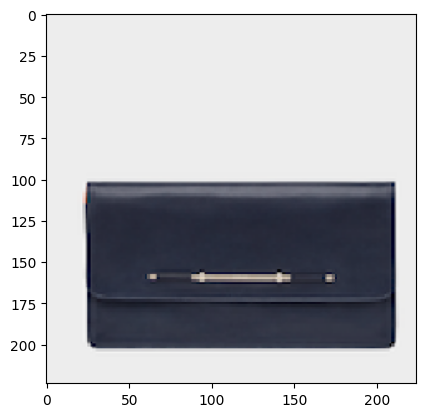

------------------------------------------------------------
Produto Mais Similar:


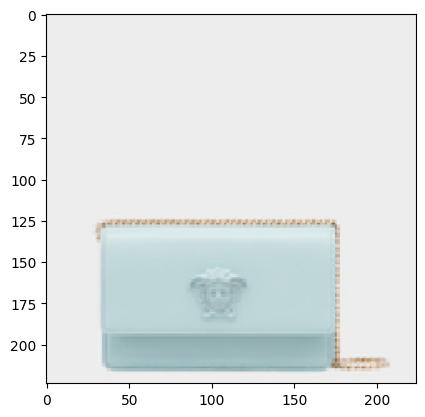

similarity score :  0.6879952


<ipython-input-25-d385e9605d63>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("similarity score : ",closest_imgs_scores[i])


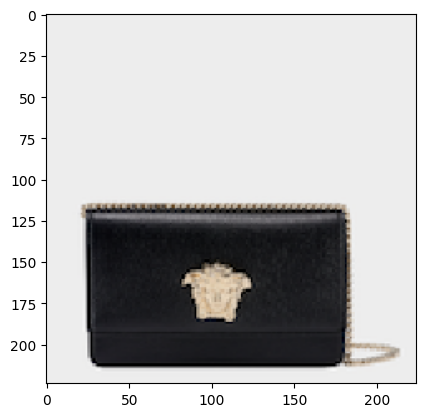

similarity score :  0.6603223


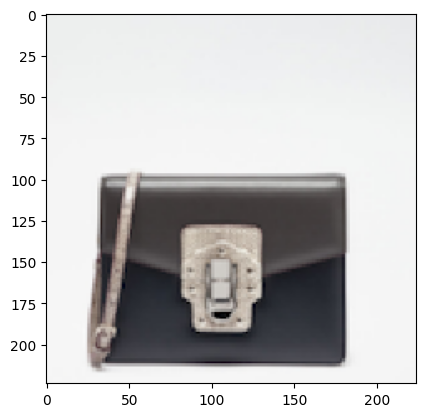

similarity score :  0.65784


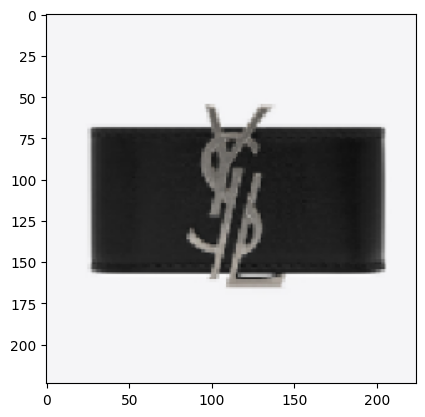

similarity score :  0.6501892


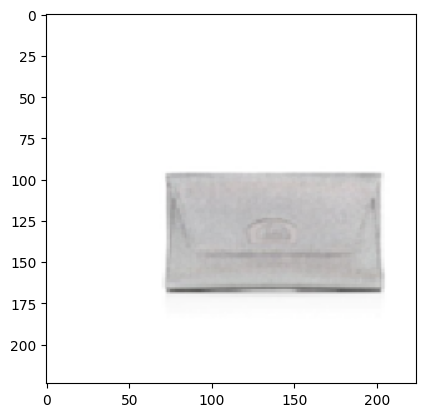

similarity score :  0.64440715


In [26]:
retrieve_most_similar_products(files[2])